# Regression Algorithms for Muon Data

We will first check some linear regression algorithms (using the negative mean square error scorer).

### Linear Regression

The ML algorithms used for linear regression are: linear regression, Lasso and the ElasticNet.

In [1]:
from pandas import read_csv
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
np.random.seed(42) #Independent from run

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

import os

In [3]:
from sklearn.model_selection import train_test_split

Load the csv into a pandas dataframe

In [4]:
filename = '../MuonPOGAnalysisTemplate/output/bxcut_org.csv'
dataframe = read_csv(filename)
array = dataframe.values
dataframe

,Event,n_Primitive,1dtPrimitive.id_r,2dtPrimitive.id_r,3dtPrimitive.id_r,4dtPrimitive.id_r,1dtPrimitive.id_eta,2dtPrimitive.id_eta,3dtPrimitive.id_eta,4dtPrimitive.id_eta,...,2dtPrimitive.quality,3dtPrimitive.quality,4dtPrimitive.quality,delta_phi12,delta_phi13,delta_phi14,delta_phi23,delta_phi24,delta_phi34,genParticle.pt
0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,6.0,5.0,6.0,0.027832,0.048096,0.057861,0.020264,0.030029,0.009766,9.452828
1,2.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,6.0,0.0,0.0,6.283512,5.961246,5.961246,0.322266,0.322266,0.000000,164.478928
2,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,6.0,5.0,0.0,0.004150,0.004639,1.816158,0.000488,1.812007,1.811519,91.713860
3,4.0,4.0,1.0,1.0,1.0,1.0,-1.0,-2.0,-2.0,-2.0,...,6.0,6.0,2.0,0.001709,0.002441,0.002686,0.000732,0.000977,0.000244,139.442352
4,5.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,...,3.0,3.0,0.0,0.009277,0.017334,5.301661,0.026611,5.292384,5.318995,198.223480
5,6.0,1.0,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.432199,4.432199,4.432199,0.000000,0.000000,0.000000,47.726688
6,7.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,5.0,2.0,0.0,0.001221,0.002114,4.004464,0.000894,4.003243,4.002350,146.894150
7,8.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,6.0,6.0,6.0,0.001221,0.002197,0.002441,0.000977,0.001221,0.000244,149.884445
8,9.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,...,5.0,0.0,0.0,0.002197,1.042071,1.042071,1.039873,1.039873,0.000000,74.841820
9,10.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,5.0,5.0,6.0,0.000977,0.001709,0.002197,0.000732,0.001221,0.000488,159.808716


The first option is divide the train/set in due different datasets.

In [5]:
X = array[:,0:len(dataframe.columns)-1]
Y = array[:,len(dataframe.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


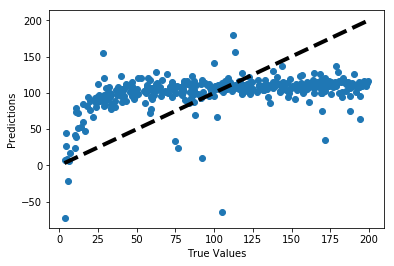

In [6]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel("True Values")
ax.set_ylabel("Predictions")
plt.show()
del ax

The other option is to use a Kfold for cross_validation

LR: -2690.234397 (311.057847)


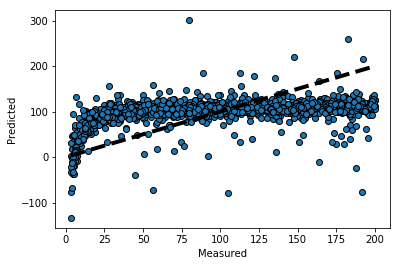

LAR: -2665.480983 (315.311276)


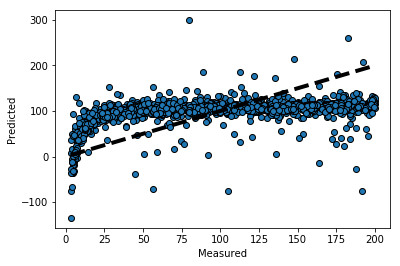

RIR: -2684.025669 (312.497146)


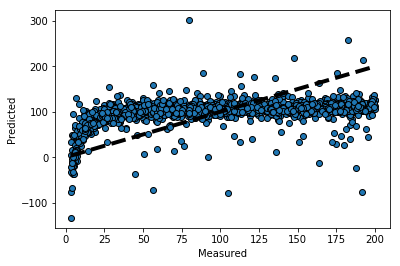

EN: -2662.741549 (315.527951)


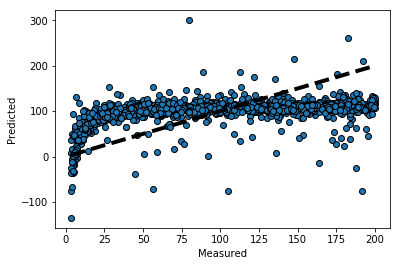

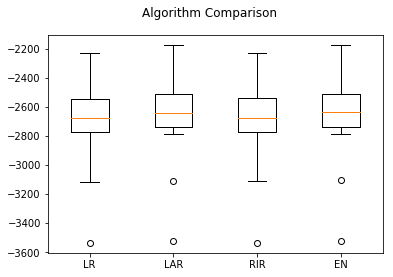

In [7]:
#load dataset
filename = '../MuonPOGAnalysisTemplate/output/bxcut_org.csv'
dataframe = read_csv(filename)
array = dataframe.values
dataframe
X = array[:,0:len(dataframe.columns)-1]
Y = array[:,len(dataframe.columns)-1]

#prepare models
models = []
models.append(( 'LR' , LinearRegression()))
models.append(( 'LAR' , Lasso()))
models.append(( 'RIR' , Ridge()))
models.append(( 'EN' , ElasticNet()))

#evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name,model in models:
    kfold = KFold(n_splits=15, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    predicted = cross_val_predict(model, X, Y, cv=kfold)
    fig, ax = plt.subplots()
    ax.scatter(Y, predicted, edgecolors=(0, 0, 0))
    ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    del ax

    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


### Non linear Regression

The non linear regression algorithms are: KNeighbotsRegressor, DecisionTreeRegressor, SVR 

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

KNR: 56.186509 (26.820611)


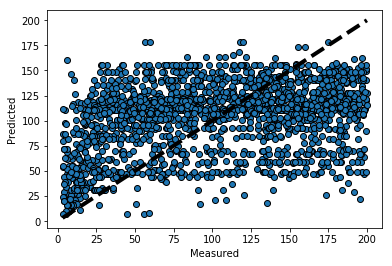

DTR: 37.058318 (13.143480)


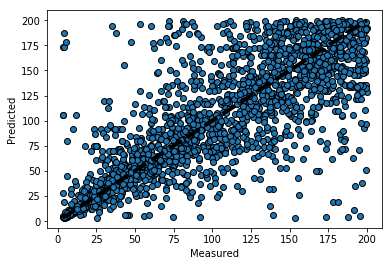

SVR: 57.040366 (12.849779)


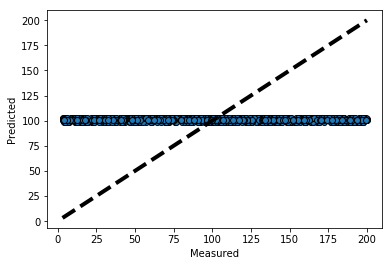

RFR: 29.275547 (10.040119)


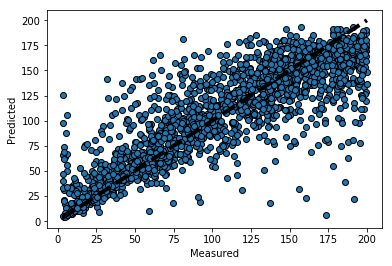

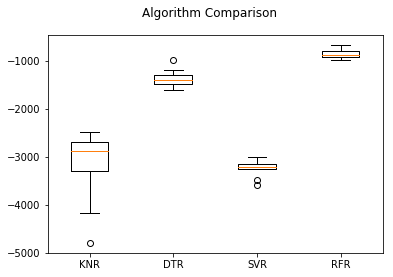

In [9]:
#load dataset
filename = '../MuonPOGAnalysisTemplate/output/bxcut_org.csv'
dataframe = read_csv(filename)
array = dataframe.values
dataframe
X = array[:,0:len(dataframe.columns)-1]
Y = array[:,len(dataframe.columns)-1]

#prepare models
models = []
models.append(( 'KNR' , KNeighborsRegressor()))
models.append(( 'DTR' , DecisionTreeRegressor()))
models.append(( 'SVR' , SVR()))
models.append(( 'RFR' , RandomForestRegressor()))

#evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name,model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse = np.sqrt((-1)*cv_results.mean())
    msg = "%s: %f (%f)" % (name, rmse, np.sqrt(cv_results.std()))
    print(msg)
    predicted = cross_val_predict(model, X, Y, cv=kfold)
    fig, ax = plt.subplots()
    ax.scatter(Y, predicted, edgecolors=(0, 0, 0))
    ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    del ax

    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



As we can see, there is no clear prediction of target label

## Try with stratified shuffle and split cross-validation

Another technique that we can use to split train/test dataset is the so called *Stratified Shuffle split* cross-validation.

The shuffle-split iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.
The word **stratified** simply groups the dataset into similar distributed entries.

* The first idea is to merge the 5-case primitive and the 1-case primitive muons in the contiguous group (4 and 2 respectively).

In [10]:
# Label those below 2 as 2
# Label those above 4 as 4
dataframe["n_Primitive_category"] = np.ceil(dataframe["n_Primitive"])
dataframe["n_Primitive_category"].where(dataframe["n_Primitive"] < 5, 4.0, inplace=True)
dataframe["n_Primitive_category"].where(dataframe["n_Primitive"] > 1, 2.0, inplace=True)

The next step is to perform the stratified shuffle split

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
split = StratifiedShuffleSplit(n_splits=8, test_size=0.3, random_state=42)
for train_index, test_index in split.split(dataframe, dataframe["n_Primitive_category"]):
    strat_train_set = dataframe.loc[train_index]
    strat_test_set = dataframe.loc[test_index]

It is necessary to remove the temporary column that is useless to train

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("n_Primitive_category", axis=1, inplace=True)

Here we can see how the new dataset is formed (both for training and test)

In [14]:
strat_train_set.head()

,Event,n_Primitive,1dtPrimitive.id_r,2dtPrimitive.id_r,3dtPrimitive.id_r,4dtPrimitive.id_r,1dtPrimitive.id_eta,2dtPrimitive.id_eta,3dtPrimitive.id_eta,4dtPrimitive.id_eta,...,2dtPrimitive.quality,3dtPrimitive.quality,4dtPrimitive.quality,delta_phi12,delta_phi13,delta_phi14,delta_phi23,delta_phi24,delta_phi34,genParticle.pt
1788,1812.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.001626,3.993234,3.993234,3.991607,3.991607,0.000000,79.828773
382,388.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,...,6.0,6.0,0.0,0.002197,0.002441,2.041661,0.000244,2.039464,2.039219,143.570404
656,665.0,2.0,1.0,1.0,0.0,0.0,-1.0,-2.0,0.0,0.0,...,6.0,0.0,0.0,0.002359,2.933097,2.933097,2.930738,2.930738,0.000000,87.940178
568,577.0,4.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-2.0,...,6.0,2.0,5.0,0.003662,0.006348,0.008057,0.002686,0.004395,0.001709,58.486935
1121,1136.0,2.0,1.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,...,6.0,0.0,0.0,0.001465,2.450513,2.450513,2.449049,2.449049,0.000000,80.131012


In [15]:
strat_test_set.head()

,Event,n_Primitive,1dtPrimitive.id_r,2dtPrimitive.id_r,3dtPrimitive.id_r,4dtPrimitive.id_r,1dtPrimitive.id_eta,2dtPrimitive.id_eta,3dtPrimitive.id_eta,4dtPrimitive.id_eta,...,2dtPrimitive.quality,3dtPrimitive.quality,4dtPrimitive.quality,delta_phi12,delta_phi13,delta_phi14,delta_phi23,delta_phi24,delta_phi34,genParticle.pt
1927,1953.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,...,6.0,0.0,0.0,0.002930,0.077637,0.077637,0.080566,0.080566,0.000000,153.125458
911,923.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,6.0,5.0,0.001221,0.002441,0.002930,0.001221,0.001709,0.000488,156.613953
1590,1612.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,6.0,6.0,0.007324,0.010986,0.012939,0.003662,0.005615,0.001953,33.041584
207,211.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,3.0,6.0,0.0,0.002930,0.007568,2.184971,0.004639,2.182042,2.177403,21.385517
1441,1460.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,6.0,2.0,6.0,0.001709,0.003174,0.003662,0.001465,0.001953,0.000488,119.088005


Now we divide (both training and test) into predictors and labels (supervised ML)

In [16]:
X_train = strat_train_set.drop("genParticle.pt",axis=1)
y_train = strat_train_set["genParticle.pt"].copy()

In [17]:
X_test = strat_test_set.drop("genParticle.pt",axis=1)
y_test = strat_test_set["genParticle.pt"].copy()

And we apply the ML regression algorithms in sequence on a loop:

LR: 53.543408


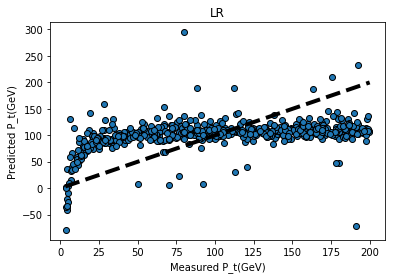

LAR: 53.108382


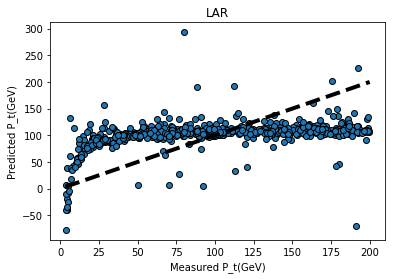

RIR: 53.402475


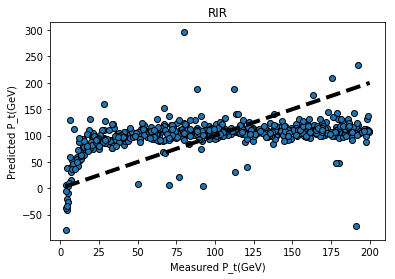

EN: 53.016731


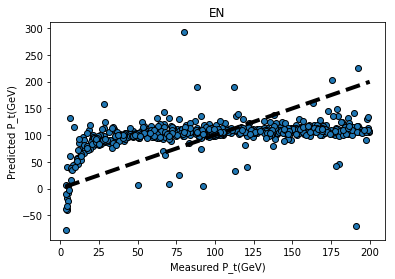

DTR: 36.321846


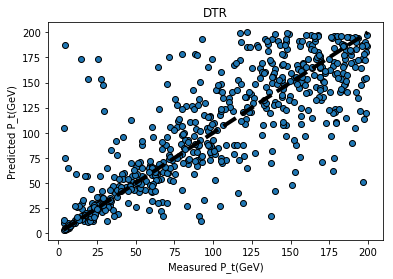

KNR: 49.320298


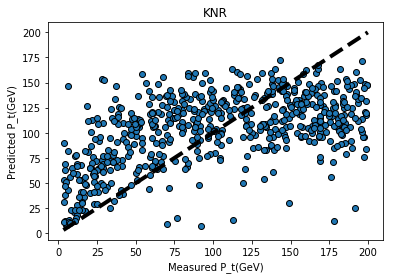

SVR: 58.374937


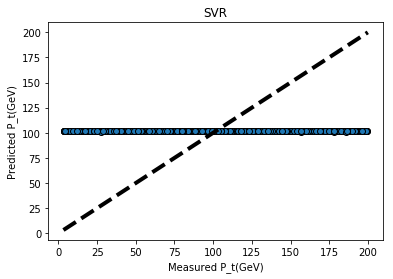

RFR: 27.644499


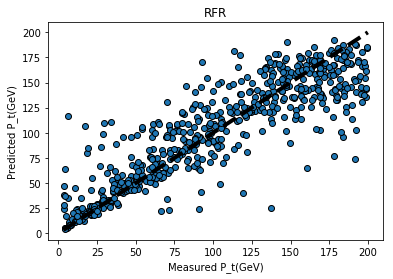

In [18]:

models = []
models.append(( 'LR' , LinearRegression()))
models.append(( 'LAR' , Lasso()))
models.append(( 'RIR' , Ridge()))
models.append(( 'EN' , ElasticNet()))
models.append(( 'DTR' , DecisionTreeRegressor(random_state=42)))
models.append(( 'KNR' , KNeighborsRegressor()))
models.append(( 'SVR' , SVR()))
models.append(( 'RFR' , RandomForestRegressor()))

#evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name,model in models:
    
    M_model = model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    
    lin_mse = mean_squared_error(y_test, prediction)
    lin_rmse = np.sqrt(lin_mse)
    msg = "%s: %f" % (name, lin_rmse)
    print(msg)
    fig, ax = plt.subplots()
    ax.scatter(y_test, prediction, edgecolors=(0, 0, 0))
    ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured P_t(GeV)')
    ax.set_ylabel('Predicted P_t(GeV)')
    ax.set_title(name)
    plt.show()
    del ax

In [19]:
some_data = X_test.iloc[:50]
some_labels = y_test.iloc[:50]